In [2]:
from itertools import islice
import pandas as pd
import numpy as np
from scipy import stats
from  qgrid import show_grid as show 
import plotly.express as px
import math
import seaborn as sns
from matplotlib import pyplot as plt 
import matplotlib as mpl
from matplotlib.lines import Line2D 
# pd.options.plotting.backend = "plotly"
pd.options.plotting.backend ='matplotlib'

mpl.rcParams['boxplot.boxprops.color'] ='white'
mpl.rcParams['boxplot.boxprops.linewidth']=2
mpl.rcParams['patch.edgecolor']='k'
mpl.rcParams['boxplot.patchartist']= "True"
mpl.rcParams['boxplot.flierprops.marker'] = 'o'
mpl.rcParams['boxplot.flierprops.color'] = 'k'
mpl.rcParams['boxplot.flierprops.markerfacecolor'] = "white"
# mpl.rc('xtick', labelsize=22) 
# mpl.rc('ytick', labelsize=22) 
mpl.rcParams['text.usetex'] = False

In [3]:
version={
    'activepython':2,
    'cython':3, 
    'nuitka':3, 
    'numba2':2, 
    'numba3':3, 
    'pypy2':2,
    'pypy3':3, 
    'cpython2':2, 
    'cpython3':3, 
    'shedskin':2
}

category={
    'activepython':"interpreter",
    'cython':"compiler", 
    'nuitka':"compiler", 
    'numba2':"library", 
    'numba3':"library", 
    'pypy2':"interpreter",
    'pypy3':"interpreter", 
    'cpython2':"interpreter", 
    'cpython3':"interpreter", 
    'shedskin':"compiler"
}
pycolors={
'shedskin' :"#641e16",
'cython' : "#e6b0aa",
'nuitka' : "#f1948a",
'numba2' : "#f36000",
'numba3' : "#f39c12",
'pypy2' : "#901ca2",
'pypy3' : "#e0b8e6",
'cpython2' : "#1b4f72",
'cpython3' : "#5dade2",
'activepython' :"#bfc9ca",
"intelpython2":"#512e5f",
"intelpython3":"#af7ac5",
"graalpython":"#a9dfbf",
"micropython":"#48c9b0",
"jython":"#117864",
"ipy":"#1f618d"


positions={    'activepython':8,
    'cython':1, 
    'nuitka':2, 
    'numba2':9, 
    'numba3':3, 
    'pypy2':7,
    'pypy3':4, 
    'cpython2':6, 
    'cpython3':5, 
    'shedskin':10
          }


reversed_positions={p:e for e, p in positions.items() }
palette=[pycolors[reversed_positions[i+1]] for i in range(len(positions))  ]

In [4]:
##### read bitops csv
def parse_bitops(filename="test_bitops20211119T204608.csv"):
    data= pd.read_csv(filename,sep=";")
    data=data.applymap(lambda x : x/ 1e6 if  type(x) == int else x) # convert units from milli to standard
    data["env"]=data["NAME"].apply(lambda x:x.split("Bit")[0].replace("bitops",""))
    data["benchmark"]=data["NAME"].apply(lambda x:x.split("BitOp")[1].split("n")[0])
    data["iteration"]=data["NAME"].apply(lambda x:int(x.split("n")[-1]))
    data["version"]=data["env"].apply(lambda x:version[x])
    data["category"]=data["env"].apply(lambda x :category[x] )
    data["position"]=data["env"].apply(lambda x: positions[x])
    data.sort_values(by=["position","version","category"],inplace=True,ignore_index=True)
    return data
data=parse_bitops()
data.head()

,NAME,WARMUP_CPU_0,WARMUP_CPU_1,WARMUP_DRAM_0,WARMUP_DRAM_1,WARMUP_DURATION_,EXECUTION_CPU_0,EXECUTION_CPU_1,EXECUTION_DRAM_0,EXECUTION_DRAM_1,EXECUTION_DURATION,env,benchmark,iteration,version,category,position
0,bitopscythonBitOpGGn0,32.853554,56.374246,13.710207,13.132220,2.062364,105.010046,175.054544,42.496561,41.024241,6.655306,cython,GG,0,3,compiler,1
1,bitopscythonBitOpLLn0,52.786975,89.993483,21.077892,20.347730,3.195464,156.399929,268.793562,63.607225,61.725478,9.901905,cython,LL,0,3,compiler,1
2,bitopscythonBitOpOrn0,5.337877,8.652687,2.066219,1.966203,0.307349,21.473334,33.401526,8.041099,7.745655,1.401859,cython,Or,0,3,compiler,1
3,bitopscythonBitOpAndn0,5.389512,8.154032,2.064459,2.004116,0.309907,22.929446,33.971654,8.218824,8.009229,1.510077,cython,A,0,3,compiler,1
4,bitopscythonBitOpXORn0,5.359728,8.454385,2.018805,1.971344,0.307771,23.431275,33.964696,8.360195,8.068394,1.542416,cython,XOR,0,3,compiler,1


In [5]:
benchmarks=['GG', 'LL', 'Or', 'A', 'XOR']
measures=["WARMUP_CPU_0","WARMUP_CPU_1","WARMUP_DRAM_0","WARMUP_DRAM_1","WARMUP_DURATION_","EXECUTION_CPU_0",
          "EXECUTION_CPU_1","EXECUTION_DRAM_0","EXECUTION_DRAM_1","EXECUTION_DURATION"]
benchmark=benchmarks[1]
measure="EXECUTION_CPU_1"

In [14]:
dt=data.groupby(["env","benchmark"]).mean().reset_index().pivot(index="env",columns=["benchmark"],values=measure).droplevel(0,axis=1)

ValueError: Cannot remove 1 levels from an index with 1 levels: at least one level must be left.

In [18]:


def add_line(ax, xpos):
    line = plt.Line2D([xpos, xpos], [1,-0.3],
                      transform=ax.transAxes, color='black')
    line.set_clip_on(False)
    ax.add_line(line)

def get_ratio(data)  :
    separator=data.groupby("version").count()
    separator=separator.loc[3][0]/(separator.loc[2][0]+separator.loc[3][0])
    return separator
    
def plot_box(df,measure="EXECUTION_CPU_1"):
    fig, axes = plt.subplots(1, 1, figsize=(32, 14))
 
    fig=df.boxplot(by="position",column=measure,ax=axes,rot=-90,return_type="both",showfliers=False)
    fig[0].ax.set_xticklabels(list(df["env"].unique()))
    fig[0].ax.set_ylabel(ylabel="Energy Consumption (J)",labelpad=22,fontsize="30")
    fig[0].ax.get_figure().suptitle('')
    fig[0].ax.set_xlabel(xlabel='')
    
    for i in range(len(fig[0][1]['boxes'])): 
        color = pycolors[fig[0][0].get_xticklabels()[i].get_text()]
        fig[0][1]['boxes'][i].set(color="b",edgecolor='black',facecolor=color,linewidth=1)
        fig[0][1]['medians'][i].set(color="red",linewidth=0.5)
        fig[0][1]['whiskers'][i].set(color="black",linewidth=1)
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    return fig,axes


def plot_bar(data,measure="EXECUTION_CPU_1"):
    fig, axes = plt.subplots(1, 1, figsize=(32, 14))
    df = data.groupby("env").mean().sort_values("position").reset_index()
    fig=df.plot.bar(x="env",y=measure,ax=axes,rot=-90,color=palette)
    separator=get_ratio(df)

    add_line(fig,separator )
    fig.set_ylabel(ylabel="Energy Consumption (J)",labelpad=22,fontsize="30")
    fig.get_figure().suptitle('')
    fig.set_xlabel(xlabel='')
    fig.get_legend().remove()
    fig.text(x=0.5*separator*(fig.get_xlim()[1]-fig.get_xlim()[0]),y=-0.3*fig.get_ylim()[1],s='python3',ha="right",size=30)
    fig.text(x=1.5*separator*(fig.get_xlim()[1]-fig.get_xlim()[0]),y=-0.3*fig.get_ylim()[1],s='python2',ha="right",size=30)

    #     fig.annotate('python2',xy=(0.25,300),size=25)
    return fig,axes
#     fig[0].ax.legend(handles=legends, loc='lower left',fontsize='xx-large',labelspacing=1)

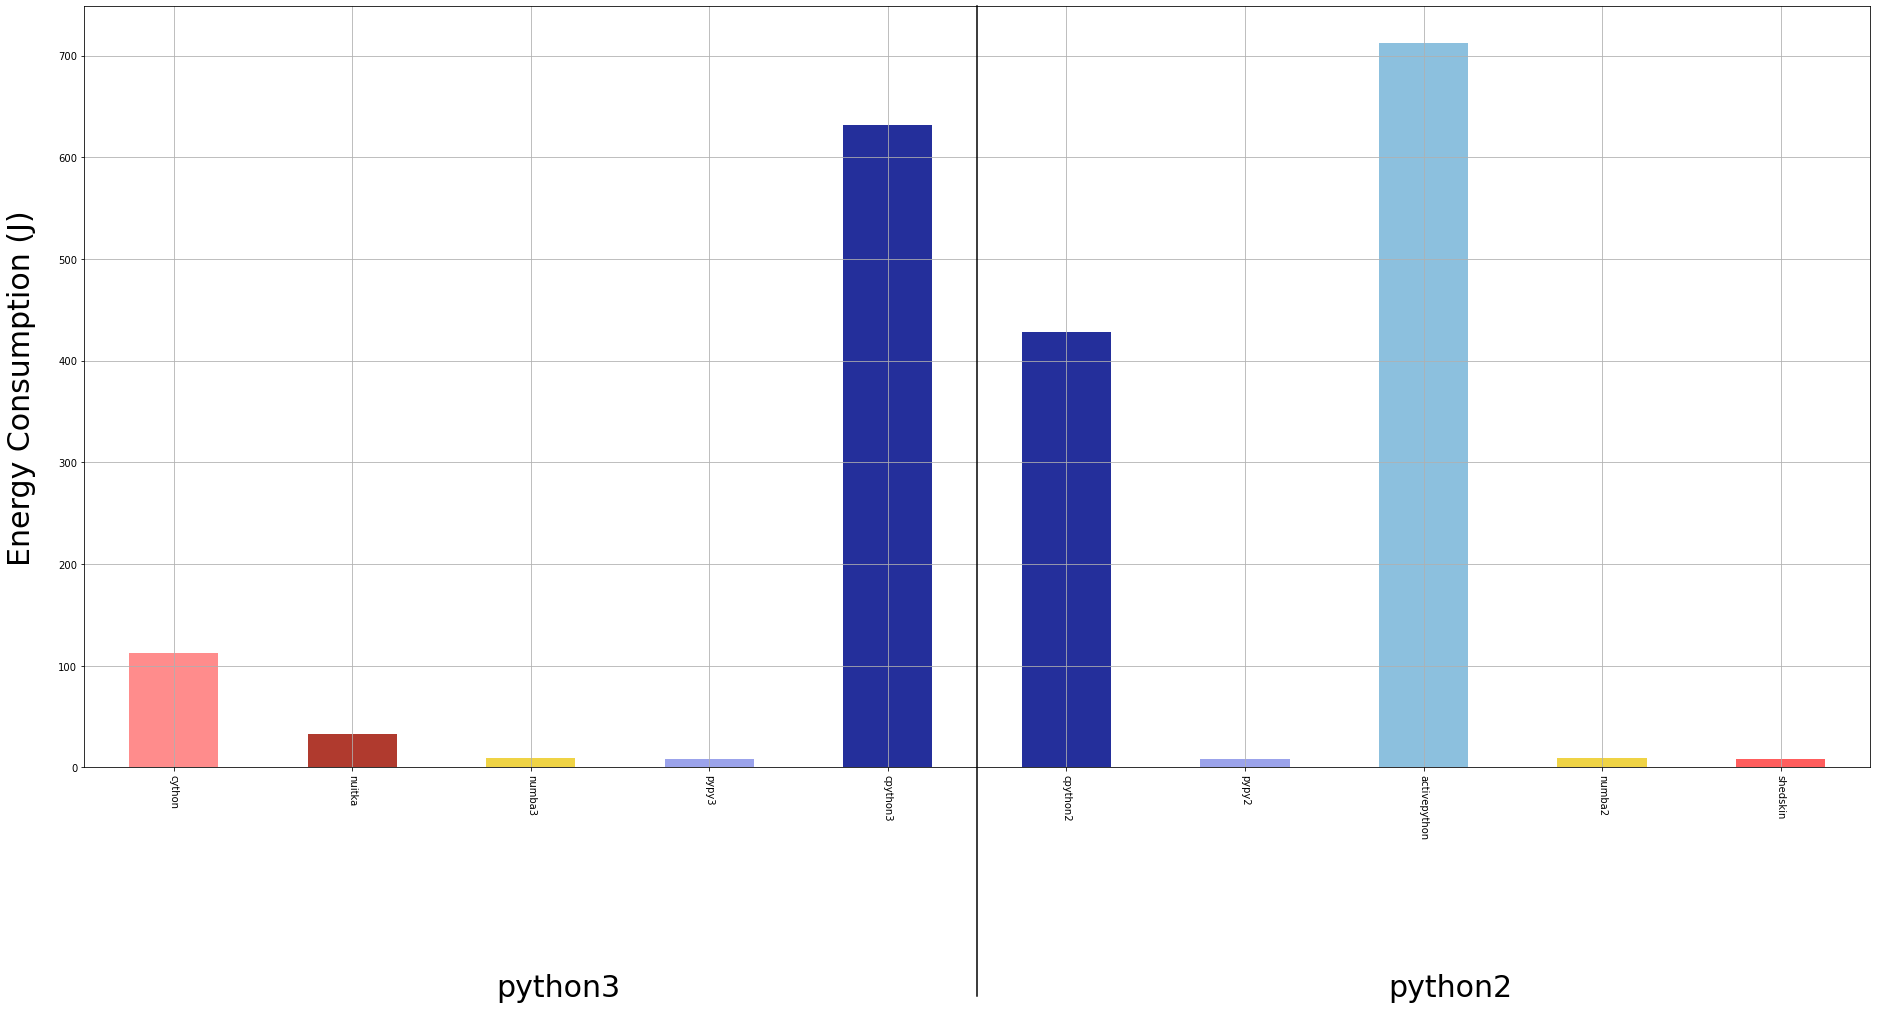

In [21]:
fig,x=plot_bar(data)
# fig.set_title("BIT operations",fontsize="30",pad=50 )
plt.grid(True)
plt.savefig("bitopts_mean.pdf")